## Objective

![](https://blog.keras.io/img/seq2seq/seq2seq-inference.png)

> 우리는 문장을 번역하는 모델을 구성해보도록 하겠습니다. **기계번역**이라 불리는 Neural Machine Translate는 파파고, 구글 번역기 등을 떠올리면 됩니다. Neural Machine Traslation에서 가장 기본적인 모델이 되는 Seq2Seq을 구현해보도록 하겠습니다.

In [2]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

<br>

# \[ 한글 영어 데이터 셋 \]
---
---

총 50개의 단문 문장 세트를 통해, 번역기를 학습시켜 보도록하겠습니다. 매우 짧은 문장으로만 구성되어 있기 때문에, 번역기다운 번역기는 만들지 못하지만, 학습되는지를 확인해보도록 하겠습니다.

In [3]:
if not os.path.exists('./short-sentence.txt'):
    !wget https://pai-datasets.s3.ap-northeast-2.amazonaws.com/alai-deeplearning/kor.txt
df = pd.read_csv("./short-sentence.txt")
df = df.sample(frac=1) # 순서를 섞어줌
df = df.reset_index(drop=True)

for idx, row in df.iloc[:5].iterrows():
    print(f"{row.Korean:16s}>>>  {row.English}")

너는 나를 사랑한다      >>>  you love me
나는 너와 친하다       >>>  I am close to you
나는 널 존중해        >>>  I respect you
나는 너를 좋아한다      >>>  I like you
나는 너가 싫어        >>>  I hate you


<br>

## 1. 데이터 파악하기
---

* 문장길이, 철자 수 등을 파악해보도록 하겠습니다.

### (1) 데이터 전처리하기

대소문자 구분은 번역에서 핵심은 아니므로, 전부 소문자로 바꾸도록 하겠습니다.

In [4]:
df.English = df.English.str.lower()

### (2) 문장 길이 파악하기

철자를 기준으로 문장 길이를 세면, 한글이 영어에 비해 짧은 구조를 가지고 있습니다.<br>
한글은 기본적으로 초성, 중성, 종성의 구조를 띄고 있기 때문입니다.

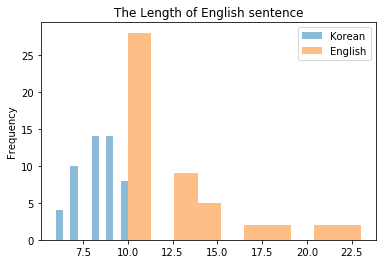

In [5]:
(df.Korean.map(lambda x : len(x))
   .plot(kind='hist', alpha=0.5,
         title='The Length of Korean sentence'))
(df.English.map(lambda x : len(x))
   .plot(kind='hist', alpha=0.5,
         title='The Length of English sentence'))
plt.legend()
plt.show()

### (2) 고유 철자 수 세기

현재 문장에서 등장했던 철자들을 파악해보도록 하겠습니다.

In [6]:
kor_chars = list(set(" ".join(df.Korean.values))) 
eng_chars = list(set(" ".join(df.English.values))) 

In [7]:
print("영어 철자 갯수 :",len(eng_chars))
print("한글 철자 갯수 :",len(kor_chars))

영어 철자 갯수 : 21
한글 철자 갯수 : 35


### (3) 특수 토큰 추가하기 

모델에서는 우리가 Padding을 의미하는 토큰과, 문장의 시작 및 끝을 의미하는 EOS 토큰이 필요합니다. 잘 쓰지 않는 특수 기호를 통해, 두 토큰을 추가하도록 하겠습니다.

In [8]:
PAD = "\t"
EOS = "\n"

kor_chars = [PAD] + kor_chars + [EOS] # \t : <padding> 토큰
eng_chars = [PAD] + eng_chars + [EOS] # \n : <eos> 토큰

kor2idx = {char : idx for idx, char in enumerate(kor_chars)}
eng2idx = {char : idx for idx, char in enumerate(eng_chars)}

In [9]:
print("한글 input size :",len(kor2idx))
print("영어 input size :",len(eng2idx))

kor_size = len(kor2idx)
eng_size = len(eng2idx)

한글 input size : 37
영어 input size : 23


두 리스트의 첫 단어로 "\t"를 추가한 것은, Padding 토큰이 영 벡터를 의미하도록 하기 위합니다.<br>
나중에 `pad_sequences` 메소드의 경우, 자동으로 영 벡터를 패딩 토큰으로 삼기 때문입니다.

In [10]:
df.Korean = df.Korean.map(
    lambda sent : [kor2idx[char] for char in sent])
df.English = df.English.map(
    lambda sent : [eng2idx[char] for char in sent])

In [11]:
# 시작과 끝에 <EOS>와 <EOS> 붙임
df.English = df.English.map(
    lambda x : [eng2idx['\n']] + x + [eng2idx['\n']])

In [12]:
for idx, row in df.loc[:5].iterrows():
    print(f"{row.Korean}>>>{row.English}")

[32, 6, 15, 28, 26, 15, 10, 7, 11, 5]>>>[22, 8, 17, 21, 9, 4, 17, 10, 12, 9, 11, 12, 22]
[28, 6, 15, 32, 23, 15, 30, 20, 5]>>>[22, 3, 9, 13, 11, 9, 18, 4, 17, 16, 12, 9, 19, 17, 9, 8, 17, 21, 22]
[28, 6, 15, 1, 15, 13, 34, 22]>>>[22, 3, 9, 1, 12, 16, 14, 12, 18, 19, 9, 8, 17, 21, 22]
[28, 6, 15, 32, 26, 15, 21, 25, 11, 5]>>>[22, 3, 9, 4, 3, 6, 12, 9, 8, 17, 21, 22]
[28, 6, 15, 32, 18, 15, 27, 31]>>>[22, 3, 9, 5, 13, 19, 12, 9, 8, 17, 21, 22]
[32, 6, 15, 28, 26, 15, 2, 4, 22]>>>[22, 8, 17, 21, 9, 5, 13, 19, 12, 9, 11, 12, 22]


### (4) 패딩 추가하기

원활한 학습을 위해, 우리는 행렬의 크기를 맞추기 위해, padding을 추가하게 됩니다.<br>
Seq2Seq을 위해서는 우리는 크게 3가지의 데이터가 필요합니다. Encoder의 입력값, Decoder의 입력값, Deocder의 출력값으로, 아래와 같이 구성할 수 있습니다.

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input_data = pad_sequences(df.Korean, padding='post')
decoder_input_data = pad_sequences(df.English, padding='post')

decoder_output_data = decoder_input_data[:,1:] # 첫 단어 떼기
decoder_output_data = pad_sequences(decoder_output_data,
                                    maxlen=decoder_input_data.shape[1],
                                    padding='post')

<br>

# Seq2Seq 모델 학습시키기

---
---

Seq2Seq모델을 제안하였던 `Sequence to Sequence Learning with Neural Networks`을 읽으며 구현해보도록 하겠습니다.RNN의 모델 경우, GPU 메모리를 매우 많이 필요로 하기 때문에, 이번 시간에서는 별도로 구현하지 않겠습니다.(논문에서는 8개의 GPU로 10일을 돌렸다고 함)


<br>

## 1. Seq2Seq의 구조 파악하기

----

* Seq2Seq 모델은 두 개의 RNN 모델을 나누어, Encoding과 Decoding을 동작시키는 모델입니다.<br>

### (1) Encoder와 Decoder

우리는 지난 시간에 배웠던 Auto Encoder의 구조를 떠올려 봅시다. <br>
Auto Encoder는 크게 Encoder와 Decoder로 나뉘어 지는데, Encoder는 큰 차원의 입력값을 작은 차원의 latent vector로 압축시키는 구조이고, decoder는 역으로 작은 차원의 latent vector를 큰 차원의 출력값으로 복원시키는 구조입니다.

이와 마찬가지로, Seq2Seq 모델도 Encoder에서 입력 순차 데이터에서 Context 정보를 뽑아내고, 이러한 정보에서 원하는 순차 데이터로 출력하는 구조입니다.

### (2) Context Vector란

Context Vector는 입력 순차 데이터에 대한 RNN 모델의 마지막 State Vector입니다.<br>
RNN Model에선 State Vector는 이전에 들어왔던 입력 정보들의 History를 담아낸 정보입니다.

그리고 보다 긴 순차 데이터의 정보들을 표현하기 위해서 주로 Vanilla RNN보다는 LSTM 모델을 이용합니다.

### (3) <EOS\> 토큰

우리는 Decoder 모델에서 첫번째 출력값과 마지막 출력값을 의미하는 토큰이 필요합니다.<br>
그렇지 않으면, Decoder 모델은 언제 출력을 멈춰야 하는지도 모른채, 계속 생성해야 할 수 있기 때문입니다.<br>

이러한 목적으로 우리는 보통 <EOS\>, End-Of-Sequence라 불리는 토큰을 이용합니다. Decoder의 입력이 시작될 때와, 출력이 마무리될 때 위의 토큰을 반환하도록 학습하게 됩니다.

<br>

## 2. Encoder-Decoder 구성하기
----


### (1) Layer 구성하기

4층만큼 깊이 하지 않고, 1층으로만 구성하도록 하겠습니다.

In [17]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import random_uniform

class Encoder(Layer):
    def __init__(self, input_size, embed_size, state_size, **kwargs):
        self.embedding_layer = Embedding(input_size, 
                                         embed_size, mask_zero=True)
        self.lstm_layer = LSTM(state_size, return_state=True)
        super().__init__(**kwargs)
        
    def call(self, inputs):
        reversed_inputs = K.reverse(inputs,axes=-1)
        embeded = self.embedding_layer(reversed_inputs)
        _, state_h, state_c = self.lstm_layer(embeded)
        return [state_h, state_c]

In [18]:
class Decoder(Layer):
    def __init__(self, output_size, embed_size, state_size, **kwargs):
        self.embedding_layer = Embedding(output_size,
                                         embed_size, mask_zero=True)
        self.lstm_layer = LSTM(state_size,return_sequences=True,
                               return_state=True)
        self.dense_layer = Dense(output_size,activation='softmax')
        super().__init__(**kwargs)
        
    def call(self, inputs, **kwargs):
        # inputs를 아래와 같이 
        dec_input = inputs[0]
        dec_states = inputs[1:]

        mode = kwargs.get('mode')

        embeded = self.embedding_layer(dec_input)
        hidden, state_h, state_c = self.lstm_layer(embeded,
                                                   initial_state=dec_states)
        output = self.dense_layer(hidden)
        
        if mode == "training":
            return output
        elif mode == "inference":
            return [output, state_h, state_c]
        else:
            raise ValueError("mode는 training 혹은 inference에서 정해야 합니다.")

### (2) 학습용 모델 구성하기


In [19]:
embed_size = 32 # 임베딩 크기
state_size = 256 # State 크기

K.clear_session()

# Training 용 Seq2Seq 모델 만들기
enc_inputs = Input(shape=(None,))
dec_inputs = Input(shape=(None,))

encoder = Encoder(kor_size, embed_size, state_size)
decoder = Decoder(eng_size, embed_size, state_size)

contexts = encoder(enc_inputs)
dec_output = decoder([dec_inputs]+contexts,
                     mode='training')

model = Model(inputs=[enc_inputs, dec_inputs],
              outputs=dec_output,
              name='training')


W0626 15:34:10.898507 4527814080 deprecation.py:323] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:3794: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### (2) 추론용 모델 구성하기

In [20]:
# Encoder Model 구성하기
encoder_model = Model(enc_inputs,contexts, name='encoder')

# Decoder Model 구성하기
dec_h_input = Input(shape=(state_size,))
dec_c_input = Input(shape=(state_size,))

state_inputs = [dec_h_input, dec_c_input]

infer_outputs = decoder([dec_inputs]+state_inputs,
                        mode='inference')

decoder_model = Model([dec_inputs]+state_inputs,
                      infer_outputs,
                      name='decoder')

<br>

## 2. 모델 학습시키기
----


### (1) 모델 컴파일하기 

In [21]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-3),
              loss=sparse_categorical_crossentropy)

### (2) 모델 학습시키기

200 Epoch 정도로 학습시켜서, Loss가 충분히 떨어진 후 Test 해보도록 하겠습니다.<br>

In [22]:
model.fit(x=[encoder_input_data, decoder_input_data],
          y=decoder_output_data,
          batch_size=8, epochs=200,
          validation_split=0.1)

Train on 45 samples, validate on 5 samples
Epoch 1/200
45/45 [==============================] - 2s 43ms/sample - loss: 1.8764 - val_loss: 1.5469
Epoch 2/200
45/45 [==============================] - 0s 10ms/sample - loss: 1.7991 - val_loss: 1.4006
Epoch 3/200
45/45 [==============================] - 0s 11ms/sample - loss: 1.6888 - val_loss: 1.3506
Epoch 4/200
45/45 [==============================] - 0s 11ms/sample - loss: 1.6171 - val_loss: 1.3587
Epoch 5/200
45/45 [==============================] - 0s 10ms/sample - loss: 1.5827 - val_loss: 1.2922
Epoch 6/200
45/45 [==============================] - 0s 11ms/sample - loss: 1.5299 - val_loss: 1.3050
Epoch 7/200
45/45 [==============================] - 1s 13ms/sample - loss: 1.4831 - val_loss: 1.2389
Epoch 8/200
45/45 [==============================] - 1s 14ms/sample - loss: 1.4585 - val_loss: 1.2645
Epoch 9/200
45/45 [==============================] - 1s 14ms/sample - loss: 1.4210 - val_loss: 1.1472
Epoch 10/200
45/45 [===================

45/45 [==============================] - 0s 11ms/sample - loss: 0.0013 - val_loss: 0.0194
Epoch 160/200
45/45 [==============================] - 0s 10ms/sample - loss: 0.0013 - val_loss: 0.0192
Epoch 161/200
45/45 [==============================] - 0s 10ms/sample - loss: 0.0013 - val_loss: 0.0191
Epoch 162/200
45/45 [==============================] - 0s 10ms/sample - loss: 0.0012 - val_loss: 0.0191
Epoch 163/200
45/45 [==============================] - 0s 10ms/sample - loss: 0.0012 - val_loss: 0.0189
Epoch 164/200
45/45 [==============================] - 0s 10ms/sample - loss: 0.0012 - val_loss: 0.0190
Epoch 165/200
45/45 [==============================] - 0s 10ms/sample - loss: 0.0012 - val_loss: 0.0191
Epoch 166/200
45/45 [==============================] - 0s 10ms/sample - loss: 0.0012 - val_loss: 0.0188
Epoch 167/200
45/45 [==============================] - 0s 10ms/sample - loss: 0.0012 - val_loss: 0.0189
Epoch 168/200
45/45 [==============================] - 0s 10ms/sample - loss: 

<br>

## 3. 최적의 출력 순차 데이터 구하기
---

* Decoding을 할 때 우리는 가장 높은 확률의 조합으로 이루어진 출력 순차 데이터를 구해야 합니다.<br>
* 그렇게 하기 위해서는 모든 출력의 조합을 확률로 계산을 해보아야 하는데, 그것은 연산량이 지나치게 많아 사실상 불가능에 가깝습니다.<br>
* 근사적인 답을 찾는 2가지 방법에 대해 배워보도록 하겠습니다.



### (1) 가장 높은 확률의 단어만 선택하기, greedy Search

기본적으로는 각 단계에서 가장 높은 확률의 조합만으로 가는 것을 Greedy Search라 부릅니다. 직관적으로 보통 가장 높은 확률의 단어만으로 갔을 때, 최적의 답이 나올 것이라 기대하는 것입니다.

In [23]:
test_sequence = "나는 너를 사랑해"

# 영어 문장을 code로 embedding하기 
test_inputs = np.array([kor2idx[char] for char in test_sequence])
test_inputs = test_inputs[np.newaxis]

# Encoder 모델을 통해 Context 벡터 계산하기
context_h, context_c = encoder_model.predict(test_inputs)
contexts = [context_h, context_c] # context 벡터

# Decoder 모델 첫 단어 구성하기
start_word = "\n"
pred_inputs = np.array([[eng2idx[start_word]]])

# Decoder을 통해 출력값 가져오기
pred_outputs = decoder_model.predict([pred_inputs]+contexts)
probs = pred_outputs[0]
states = pred_outputs[1:]

# 출력값중 가장 높은 확률값의 인덱스 가져오기
top_index = probs.argmax(axis=-1)
last_word = eng_chars[top_index.squeeze()]

# 위의 과정을 반복
pred_sequence = ""
while last_word != "\t" and last_word != "\n":
    # <EOS> 토큰이 나오거나, 멈추지 않는 현상을 방지
    pred_sequence += last_word
    
    pred_outputs = decoder_model.predict([top_index]+states)
    probs = pred_outputs[0]
    states = pred_outputs[1:]
    
    top_index = probs.argmax(axis=-1)
    last_word = eng_chars[top_index[0][0]]

print(pred_sequence)

i love you


하지만, 꼭 가장 높은 확률의 단어로만 갔을 때, 정답을 보장하지 않습니다. 이전 출력의 기록에 따라 다음 출력의 결과물들이 바뀌기 때문입니다. 특히 영어 문장에서는 첫 단어로 i가 나올 가능성이 높기 때문에, 어떤 입력 문장이든 첫 단어로 i를 반환할 가능성이 매우 높습니다. 

### (2) 몇 개의 후보군을 비교해가며 진행하기, Beam Search

Greedy Search는 원치 않은 잘못된 결과를 반환할 수 있습니다. 이를 방지하기 위해, 우리는 Beam Search라고 불리는 방법은 각 단계에서 단어를 N개 예측 후 조합하는데, 이 때 가장 확률이 높은 후보 군(Beam size)만큼을 남기고 다음 스텝을 진행하는 방식입니다. <br>
Beam Search는 일종의 Dynamic Programming입니다. 코드 난이도가 있으니 잘 살펴 보시길 바랍니다.

In [28]:
test_sequence = "나는 널 믿어"

k = 5 # Beam Search의 크기

completed_k = 0 # 완료된 서치
completed_sequences = [] # 완료된 시퀀스
completed_scores = [] # 완료된 시퀀스의 점수

live_k = k
live_sequences = np.array([[]]) # 탐색 중인 시퀀스
live_scores = np.array([0]) # 탐색 중인 점수

# 문장을 kor2idx로 인코딩하기
test_inputs = np.array([kor2idx[char] for char in test_sequence])
test_inputs = test_inputs[np.newaxis]

# Encoder 모델을 통해 Context 벡터 계산하기
context_h, context_c = encoder_model.predict(test_inputs)

# Decoder 모델 첫 단어 구성하기
start_word = "\n"
start_inputs = np.array([eng2idx[start_word]])

# Decoder 모델의 초기 상태 값 구성하기
contexts = [context_h, context_c] # context 벡터
# 그외 2개의 상태 벡터의 초깃값
other_state =[np.zeros_like(context_h) for _ in range(2)] 

initial_state = contexts + other_state 

# Decoder을 통해 출력값 가져오기
pred_outputs = decoder_model.predict([start_inputs]+initial_state)
probs = pred_outputs[0]
states = pred_outputs[1:]

while True:
    # 후보군들의 점수 계산하기
    candidate_scores = live_scores[:,None,None]-np.log(probs) # 점수 계산, 음수로 하였기 때문에 작을수록 좋은 값
    # (batch size, time steps, char size) -> (batch size, char size)
    candidate_scores = candidate_scores[:,0,:] # 단어 별로 진행하기 때문에, time steps =1 
    
    # 상위 (k-completed_k)개의 점수 
    live_scores = np.sort(candidate_scores.ravel())[:(k-completed_k)]
    
    # 상위 (k-completed_k)개의 (batch index, char index) 가져오기
    # reference : have numpy argsort return an array of 2d indices?
    # https://stackoverflow.com/questions/30577375/have-numpy-argsort-return-an-array-of-2d-indices
    rank_indices = np.dstack(
        np.unravel_index(
            np.argsort(candidate_scores.ravel()),
            candidate_scores.shape))[0,:(k-completed_k)]

    # batch index와 char index를 가져오기
    batch_indices = rank_indices[:,0] # 각 배치 별로 next state 값이 다름
    char_indices = rank_indices[:,1]  # 각 char 별로 next input 값이 다름 
    
    # 이전 시퀀스를 rank 순서에 맞게 가져오기
    prev_sequences = np.array(live_sequences)[batch_indices] # 각 배치는 이전 시퀀스를 의미
    next_words = np.array([eng_chars[idx] for idx in char_indices])[:,None] # 다음 분기에 해당하는 word 가져오기
    live_sequences = np.concatenate((prev_sequences, next_words),axis=1)
    
    del_list = []
    for idx, word in enumerate(next_words):
        if word == EOS:
            # EOS를 만나면, 그 행은 완결된 Sequence
            completed_k += 1            
            completed_seq = "".join(live_sequences[idx]) # ["i"," ","h","a","t","e",...] -> "i hate ..."
            completed_sequences.append(completed_seq) 
            # 길이가 길수록 계속 더해지기 때문에 점수가 커집니다. 장문이 기본적으로 단문보다 score가 크게 잡히기 때문에
            # 이를 보정하기 위해, 나누어 주어야 합니다.
            completed_scores.append(live_scores[idx] /len(completed_seq))
            del_list.append(idx)
            
    # 탐색 중인 시퀀스에서 제거하기, 탐색할 수는 len(del_list)만큼 줄어듦
    live_sequences = np.delete(live_sequences, del_list, axis=0)
    live_scores = np.delete(live_scores, del_list, axis=0)
    batch_indices = np.delete(batch_indices, del_list, axis=0)
    char_indices = np.delete(char_indices, del_list, axis=0)
    
    # 탐색 종료 조건
    if completed_k >= k:
        # 모든 시퀀스를 다 찾은 경우 종료
        break
    
    # 다음 Sequence에 들어갈 input 값과 상태 값 가져오기
    next_inputs = char_indices[:,None] # (num indices,) -> (num indices, 1)
    next_states = [state[batch_indices] for state in states]

    # 모델에 inference하기
    pred_outputs = decoder_model.predict([next_inputs]+next_states)
    probs = pred_outputs[0]
    states = pred_outputs[1:]

# Score에 따라 정렬하기
result = list(zip(completed_sequences, completed_scores))
result = sorted(result, key=lambda x: x[1]) # Score는 낮을수록 좋은 값
print(result)

[('i believe you\n', 0.008965726932988869), ('i relieve you\n', 0.25235972004364676), ('i hate you\n', 0.2569068585911406), ('i bespect you\n', 0.45489259238508695), ('i hete you\n', 0.5279026596412719)]


여기서 Score는 작을수록 더 정확하게 예측했다는 것을 의미합니다. "나는 너를 믿어"를 보고, 가장 유사한 번역 후보군 5개로 위의 것들을 추론했고, 그 중 i believe you가 가장 높은 값을 보였습니다.

## Reference

1. [Seq2Seq Paper](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf)
2. [Visualizing A Neural Machine Translation Model ](http://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)
3. [Keras를 이용해 Seq2Seq을 10분안에 알려주기](https://tykimos.github.io/2018/09/14/ten-minute_introduction_to_sequence-to-sequence_learning_in_Keras/)